## Replication of http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture16.pdf, slide 11

**Surprising result**: behavior is only present when network is trained!!!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from resnet import *
from vgg import *

In [2]:
transform_normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = dset.CIFAR10('./dataset', train=True, download=True,
                       transform=transform_normalize)
trainloader = DataLoader(trainset, batch_size=20, shuffle=True)

In [130]:
model = ResNet18()
# model = VGG('VGG11')

In [4]:
param_count = 0
for param in model.parameters():
    param.requires_grad = False
    param_count += np.prod(param.size())
print(param_count)

11173962


# Interpolation before training

In [ ]:
def plot_interpolation(X, g, img=img, img_var=img_var):
    Y = []
    plt.figure(figsize=(6, 6))
    for i in range(10):
        Y.append([])
        for x in X:
            img += x * g
            scores = model(img_var)
            img -= x * g
            y = scores.squeeze().data[i]
            Y[i].append(y)
        plt.plot(X, Y[i], label=str(i))
    plt.legend(loc='upper left')
    plt.show()
images, labels = iter(trainloader).next()

img = torch.FloatTensor(images[5:6])
img_var = Variable(img, requires_grad=True)

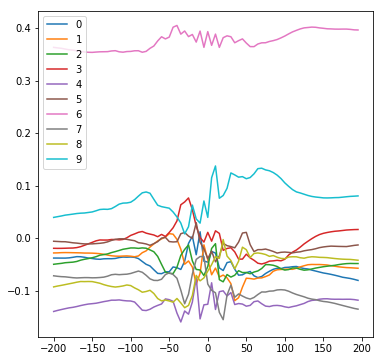

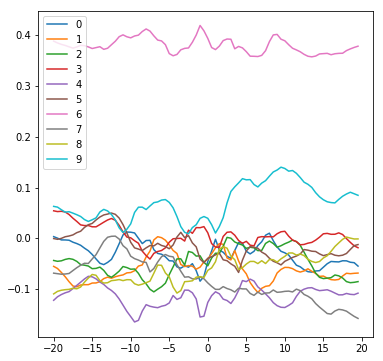

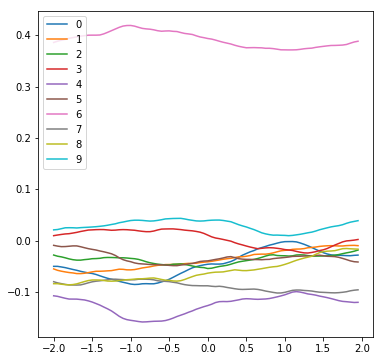

In [6]:
# random direction
g = torch.FloatTensor(np.random.randn(32, 32))
g = g / g.norm()

plot_interpolation(np.arange(-200, 200, 5))
plot_interpolation(np.arange(-20, 20, .5))
plot_interpolation(np.arange(-2, 2, .05))

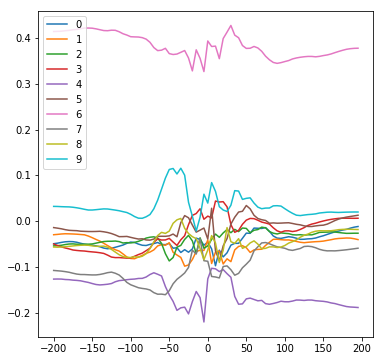

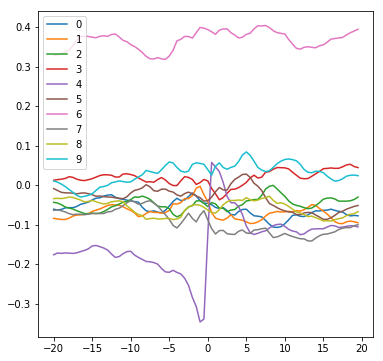

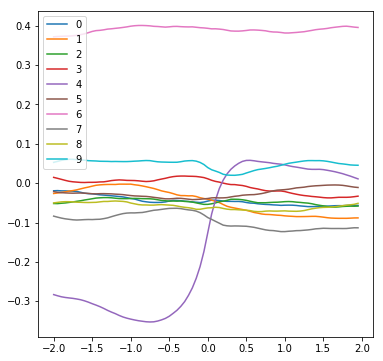

In [7]:
# find adversarial direction
scores = model(img_var)
objective = scores.squeeze()[4]
objective.backward()
g = img_var.grad.data
g = g / g.norm()

plot_interpolation(np.arange(-200, 200, 5))
plot_interpolation(np.arange(-20, 20, .5))
plot_interpolation(np.arange(-2, 2, .05))

## Train the network (resnet18)

In [134]:
def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval()
    for X, y in loader:
        X_var = Variable(X.type(gpu_dtype), volatile=True)

        scores = model(X_var)
        _, preds = scores.data.cpu().max(1)

        num_correct += (preds == y).sum()
        num_samples += preds.size(0)

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

def train(loader_train, model, criterion, optimizer):
    model.train()
    for t, (X, y) in enumerate(loader_train):
        X_var = Variable(X.type(gpu_dtype))
        y_var = Variable(y.type(gpu_dtype)).long()

        scores = model(X_var)

        loss = criterion(scores, y_var)
        if (t+1) % 100 == 0:
            print('t = %d, loss = %.4f' % (t+1, loss.data[0]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

class ChunkSampler(sampler.Sampler):
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
    
    def __iter__(self):
        return iter(range(self.start, self.start+self.num_samples))
    
    def __len__(self):
        return self.num_samples

In [36]:
transform_augment = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4)])
transform_normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# get CIFAR-10 data
NUM_TRAIN = 45000
NUM_VAL = 5000
BATCH_SIZE = 128
cifar10_train = dset.CIFAR10('./dataset', train=True, download=True,
                             transform=T.Compose([transform_augment, transform_normalize]))
loader_train = DataLoader(cifar10_train, batch_size=BATCH_SIZE,
                          sampler=ChunkSampler(NUM_TRAIN))
cifar10_val = dset.CIFAR10('./dataset', train=True, download=True,
                           transform=transform_normalize)
loader_val = DataLoader(cifar10_train, batch_size=BATCH_SIZE,
                        sampler=ChunkSampler(NUM_VAL, start=NUM_TRAIN))
cifar10_test = dset.CIFAR10('./dataset', train=False, download=True,
                            transform=transform_normalize)
loader_test = DataLoader(cifar10_test, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [145]:
if not torch.cuda.is_available():
    print('Error: CUDA library unavailable on system')
gpu_dtype = torch.cuda.FloatTensor
model = model.type(gpu_dtype)
for p in model.parameters():
    p.requires_grad = True
model.train()
pass

In [146]:
# setup loss function
criterion = nn.CrossEntropyLoss().cuda()
# train model
# SCHEDULE_EPOCHS = [50, 5, 5] # divide lr by 10 after each number of epochs
SCHEDULE_EPOCHS = [5, 1, 1]
# SCHEDULE_EPOCHS = [100, 50, 50] # divide lr by 10 after each number of epochs
learning_rate = 0.1
for num_epochs in SCHEDULE_EPOCHS:
    print('Training for %d epochs with learning rate %f' % (num_epochs, learning_rate))
    optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                          momentum=0.9, weight_decay=1e-3)
    for epoch in range(num_epochs):
        check_accuracy(model, loader_val)
        print('Starting epoch %d / %d' % (epoch+1, num_epochs))
        train(loader_train, model, criterion, optimizer)
    learning_rate *= 0.1

Training for 5 epochs with learning rate 0.100000
Got 544 / 5000 correct (10.88)
Starting epoch 1 / 5
t = 100, loss = 0.7596
t = 200, loss = 0.7294
t = 300, loss = 0.6659
Got 3461 / 5000 correct (69.22)
Starting epoch 2 / 5
t = 100, loss = 0.6528
t = 200, loss = 0.7431
t = 300, loss = 0.6413
Got 3108 / 5000 correct (62.16)
Starting epoch 3 / 5


KeyboardInterrupt: 

# Run the same experiments

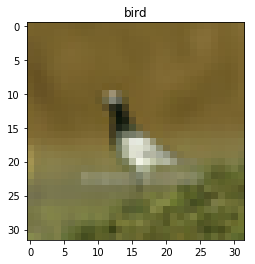

In [169]:
from utils import *

for param in model.parameters():
    param.requires_grad = False

i = 7
    
images, labels = iter(trainloader).next()
img = torch.cuda.FloatTensor(images[i, np.newaxis].cuda())
img_var = Variable(img, requires_grad=True)

def plot_interpolation(g, X, img=img, img_var=img_var):
    Y = []
    plt.figure(figsize=(6, 6))
    for i in range(10):
        Y.append([])
        for x in X:
            d = (x * g).type(gpu_dtype)
            img += d
            scores = model(img_var)
            img -= d
            y = scores.squeeze().data[i]
            Y[i].append(y)
        plt.plot(X, Y[i], label=str(i))
    plt.legend(loc='upper left')
    plt.show()

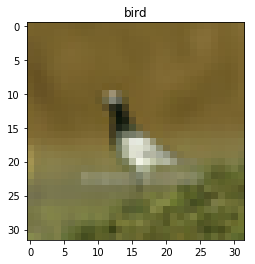

bird
bird


In [174]:
imshow(images[i], labels[i])
print(CIFAR_CLASSES[labels[i]])
print(CIFAR_CLASSES[model(img_var).max(1)[1].data[0]])

In [186]:
g = torch.FloatTensor(np.random.randn(32, 32))
g = g / g.norm()
g = g.type(gpu_dtype)
gnp = g.cpu().numpy()
image2 = images[i].numpy() + 10 * gnp
imshow(gpu_dtype(image2).cpu(), labels[i])

ValueError: Floating point image RGB values must be in the 0..1 range.

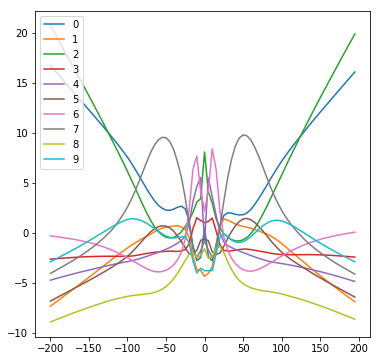

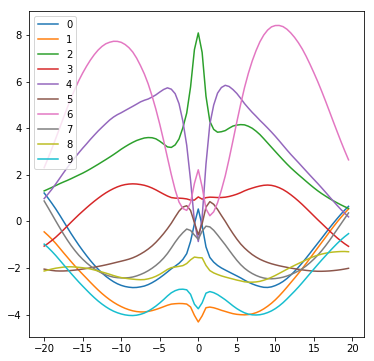

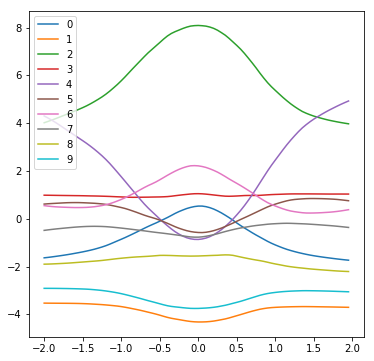

In [170]:
# random direction
g = torch.FloatTensor(np.random.randn(32, 32))
g = g / g.norm()
g = g.type(gpu_dtype)

plot_interpolation(g, np.arange(-200, 200, 5))
plot_interpolation(g, np.arange(-20, 20, .5))
plot_interpolation(g, np.arange(-2, 2, .05))

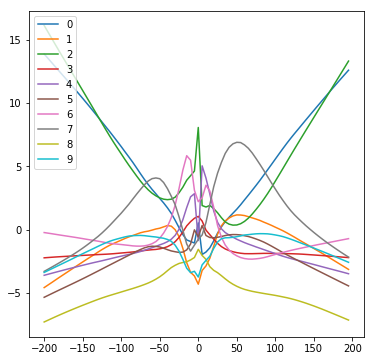

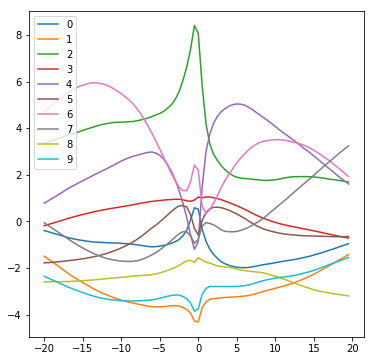

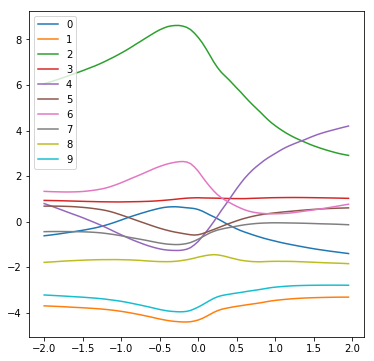

In [171]:
# find adversarial direction
scores = model(img_var)
objective = scores.squeeze()[4]
objective.backward()
g = img_var.grad.data
g = g / g.norm()

plot_interpolation(g, np.arange(-200, 200, 5))
plot_interpolation(g, np.arange(-20, 20, .5))
plot_interpolation(g, np.arange(-2, 2, .05))